### 天梯最终版，将所有学校都考虑进来，调整了每一轮得分和b的取值的计算顺序

In [1]:
from impala.dbapi import connect
import pandas as pd
from collections import defaultdict
import trueskill as ts
import multiprocessing as mps
import numpy as np

### 连接HUE数据库

In [2]:
conn = connect(host='10.8.8.21', port=10015, auth_mechanism='PLAIN', database='tmp', user='shenfei',password='123456')
cursor = conn.cursor()

   ### 从数据库中取出数据。共取出以下数据字段：
- id，用户id，题目id，做题时长，日期，正确与否(0/1)，该用户对应的学校名，该题目对应的知识点id(goal)

### 再将取出的数据转成DataFrame格式，方便以后使用
- 关于排序：先对day进行排序，再对时间戳time排序。时间戳time是用户设备上的时间，故出错的更多，先用必对的day限制一下

In [3]:
cursor.execute('''
SELECT t1.*, t2.goal_id
FROM
(
    SELECT id, u_user, problem_id,duration, day, correct, u_school, from_unixtime(event_time/1000) AS time
    FROM events.frontend_event_orc
    WHERE day BETWEEN 20181001 AND 20181031
      AND event_key = 'clickLTTPSumbit'
      AND u_user != ''
      AND u_user IS NOT NULL
      AND u_school IS NOT NULL
      AND u_school IN ('新民中学', '莒南七中', '临沂十一中', '南宁二中', '广东实验中学', '双语学校', '武陵中学', '吴有训实验学校', '武侯实验中学', '城关中学')
)t1
INNER JOIN
(
    SELECT id, goal_id
    FROM course.problem
)t2 ON t1.problem_id = t2.id
ORDER BY t1.day,t1.time ASC
''')

data = cursor.fetchall()
data = pd.DataFrame(data)
data.columns = ['id', 'uid', 'pid', 'dur', 'day', 'corr', 'sch_name', 'time', 'gid']
data['ts_pts'] = 0 

### 来看看我们取出来的数据，转换成DataFrame之后是啥样子吧！

In [16]:
data.tail()

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts
271765,5bd9cba44e4fa563c936b8e9,5bd9987437a1c6078d7ba48a,b2435856-57e8-11e7-b7dc-47b64a07c69f,16397,20181031,1,新民中学,2018-10-31 23:34:45,967146a8-53f4-11e7-8607-cb93d0916896,0
271766,5bd9cbad4e4fa563c936d148,5bd9c9fbcf147b078d6fe60f,0b6869f8-7b3e-11e7-978a-4f2fac895fe7,8761,20181031,1,新民中学,2018-10-31 23:34:47,9641fbfa-53f4-11e7-85fb-6faae314e5b8,0
271767,5bd9cbb64e4fa563c936e85b,5bd9987437a1c6078d7ba48a,6e6db642-7be9-11e7-840d-5f67cb1d6f14,16818,20181031,1,新民中学,2018-10-31 23:35:03,967146a8-53f4-11e7-8607-cb93d0916896,0
271768,5bd9cbbc4e4fa563c936f60e,5bd9c9fbcf147b078d6fe60f,62683afa-7b41-11e7-b9df-c378678c4252,21603,20181031,1,新民中学,2018-10-31 23:35:09,9645f6c4-53f4-11e7-85fc-7b1f9c0df003,0
271769,5bd9cbc84e4fa563c9371bb2,5bd99ca5d508f43a0f3a7d9b,aa2dd4d4-57e8-11e7-b540-678dfbf542e6,43869,20181031,1,新民中学,2018-10-31 23:35:21,969730b6-53f4-11e7-8612-7b98a235568d,0
271770,5bd9cbd44e4fa563c9373ad7,5bd9987437a1c6078d7ba48a,b240da90-57e8-11e7-b7db-77feab92df43,9761,20181031,1,新民中学,2018-10-31 23:35:27,967146a8-53f4-11e7-8607-cb93d0916896,0
271771,5bd9cbcb4e4fa563c937234b,5bd9c9fbcf147b078d6fe60f,1a50d150-7b41-11e7-a0ce-938c8e8d80bc,6630,20181031,1,新民中学,2018-10-31 23:35:29,9645f6c4-53f4-11e7-85fc-7b1f9c0df003,0
271772,5bd9cbcb4e4fa563c9372367,5bd9c9fbcf147b078d6fe60f,e238610c-7b40-11e7-b9dd-fbe26b91c3f4,5028,20181031,1,新民中学,2018-10-31 23:35:35,9645f6c4-53f4-11e7-85fc-7b1f9c0df003,0
271773,5bd9cbda4e4fa563c937501a,5bd9c9fbcf147b078d6fe60f,1f930b1c-7b3f-11e7-bc77-2b4674541bba,4576,20181031,0,新民中学,2018-10-31 23:35:40,9645f6c4-53f4-11e7-85fc-7b1f9c0df003,0
271774,5bd9cbd44e4fa563c9373af8,5bd9987437a1c6078d7ba48a,8e4f2e2a-7be2-11e7-bb52-c7a4f76eb0d3,13446,20181031,0,新民中学,2018-10-31 23:35:41,967146a8-53f4-11e7-8607-cb93d0916896,0


In [5]:
len(data),data.index   # 相比于之前的，数据量竟然是原来的1/3，开心。。。

(269904, RangeIndex(start=0, stop=269904, step=1))

$$compensate = \left (\frac{\mu_{g}}{\mu_{u}} - 1  \right ) \cdot b$$  
在此十所学校数据集中，$$(b\approx 0.043)$$
$$\Delta = \frac{\mu_g}{\mu_u} \cdot norm\_d(duration) + compensate,$$
where
<img src="https://images-cdn.shimo.im/zkpSlHD52FE0vDaz/%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7_2018_06_11_%E4%B8%8B%E5%8D%882.45.06.png!thumbnail" style="width:500px"/>
(when 'corr' == 1)

In [6]:
def norm_duration(item):
    d = item['dur']
    d = max(2000, d)
    d = min(d, 600000)
    
    x = 2000/d
    x = x if item['corr'] == 1 else (1-x+2000/600000)
    return x ** 0.3

### 按照gid，对duration进行分组，然后根据duration的长短（数据分箱）对该时长的正确率进行计算。

In [111]:
# 先把数据取出来，然后按照gid分组，然后每个gid的做题记录按照dur时长排序，先看一眼数据
pick_dur = data[['gid','dur','corr']]
df = pick_dur.groupby('gid').apply(lambda x:x.sort_values(by='dur'))
goal_sort = pick_dur.groupby('gid').apply(lambda x:len(x)).sort_values(ascending=False)
goal_sort.index[0]

'9690ebf2-53f4-11e7-8610-ffb838397af0'

### 等用户数分组——确保每个组内有足够的用户数，不会出现异常值：

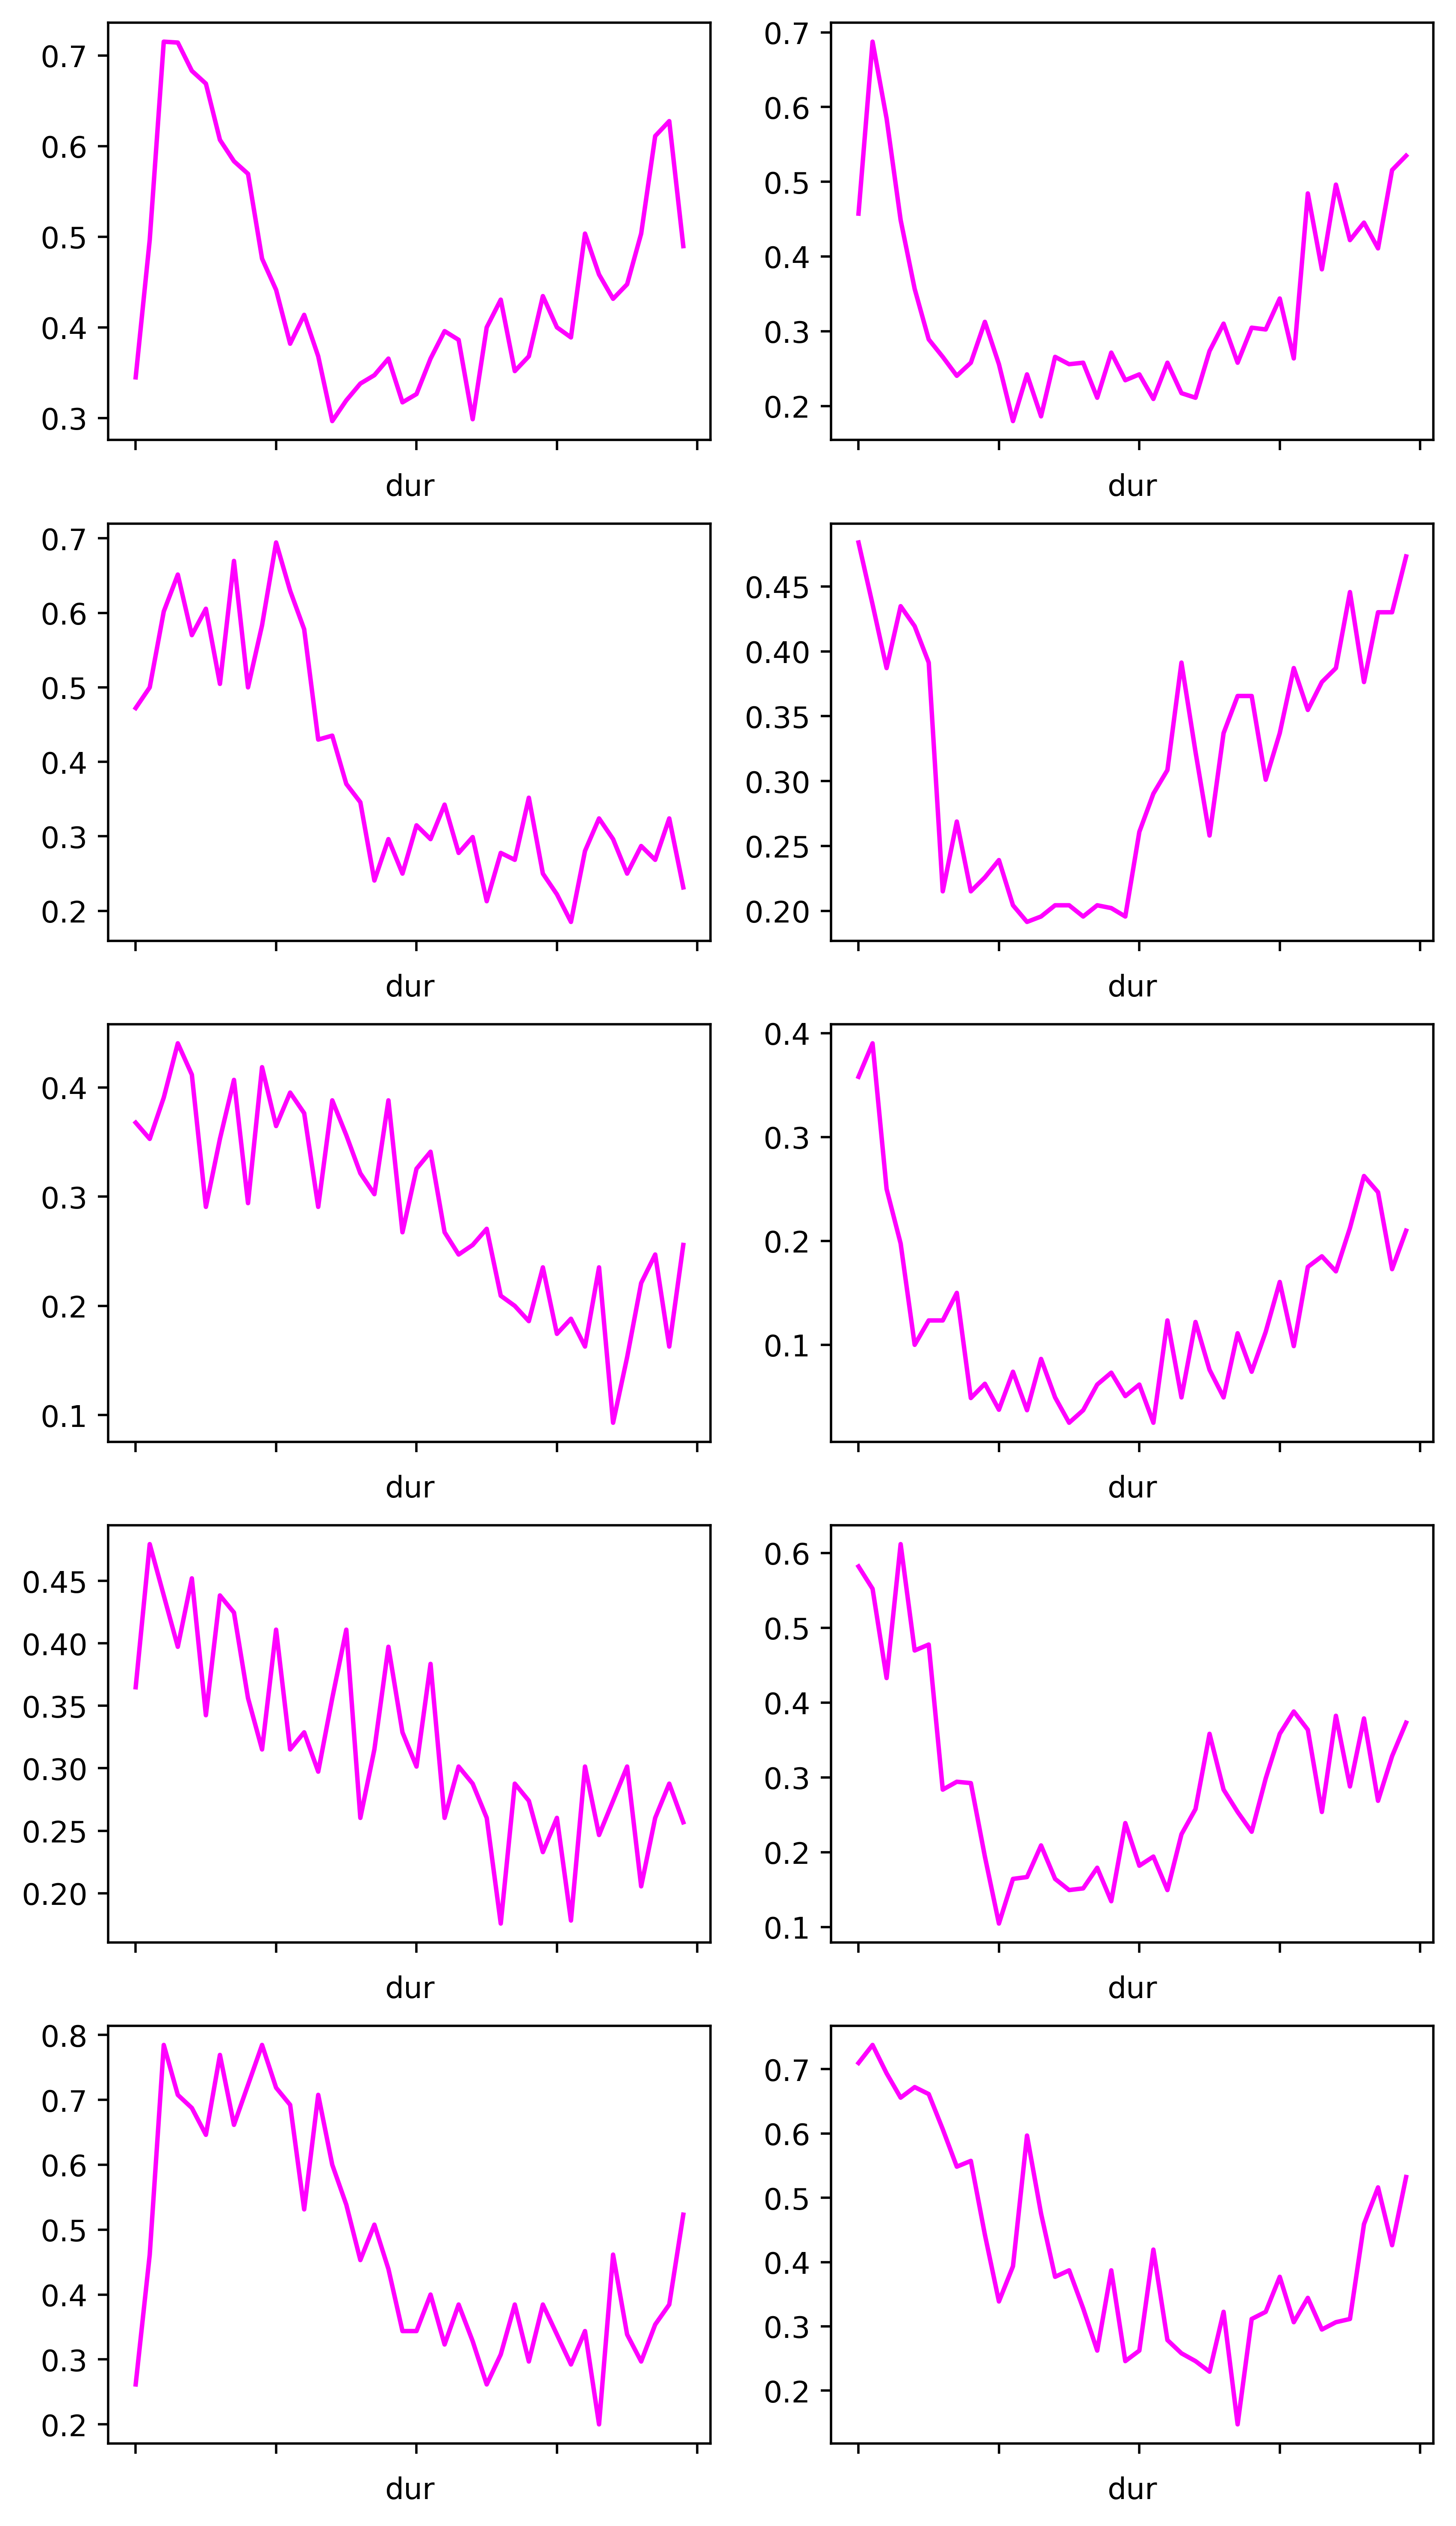

In [129]:
# 对分好组的数据，展示前十个gid对应的做题记录下，dur时长和corr正确率之间的关系。
# 到底用cut还是qcut呢？感觉还是cut更合理吧，一会儿都试一下，先试试qcut
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(8,15),dpi=500)
size = 10
ax = list(range(size))
for i in range(size):
    ax[i] = fig1.add_subplot(size/2,2,i+1)
    
    # 根据qcut进行数据分箱，按照分箱结果进行groupby分组，并对每组的数据的corr进行加和，计算正确率
    # qcut数据分箱参数——每个goal下的duration均分成15个区间，毕竟每个区间数据太少了计算出来的正确率也可能会有偶然性
    # 1,先取出对应轮次的goal的所有记录（第一轮就是goal1）：
    record = pick_dur[pick_dur.gid == goal_sort.index[i]]
    # 2,对取到的数据进行分箱，按照分箱结果groupby分组，组内计算正确率,然后直接画出来：
    data_draw = record.groupby(pd.qcut(record['dur'],q=40)).apply(lambda x:sum(x['corr'] == 0)/len(x))
    data_draw.plot(kind='line',colormap='spring')

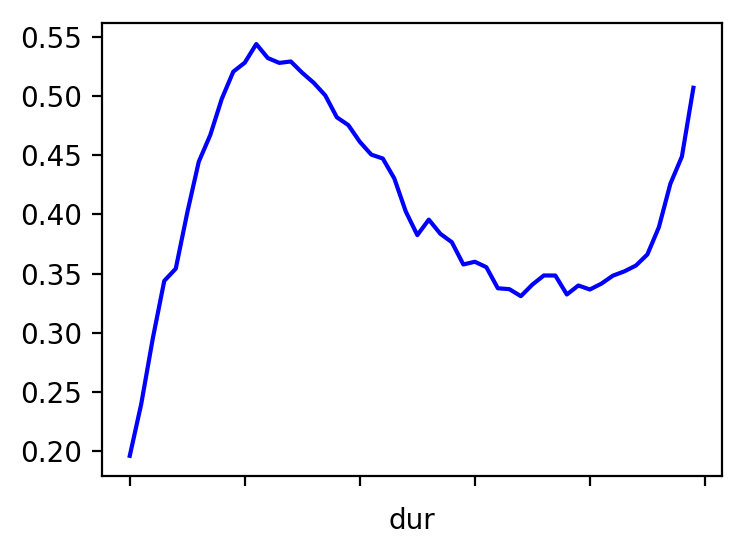

In [138]:
draw_qcut = pick_dur.groupby(pd.qcut(pick_dur.dur,q=50)).apply(lambda x:sum(x['corr']==0)/len(x))
fig3 = plt.figure(figsize=(4,3),dpi=200)
ax3 = fig3.add_subplot(111)
draw_qcut.plot(kind='line',colormap='winter')

### 等区间分组——防止某一区间人太少导致的区间篡位的问题，但相应的也可能会有异常：

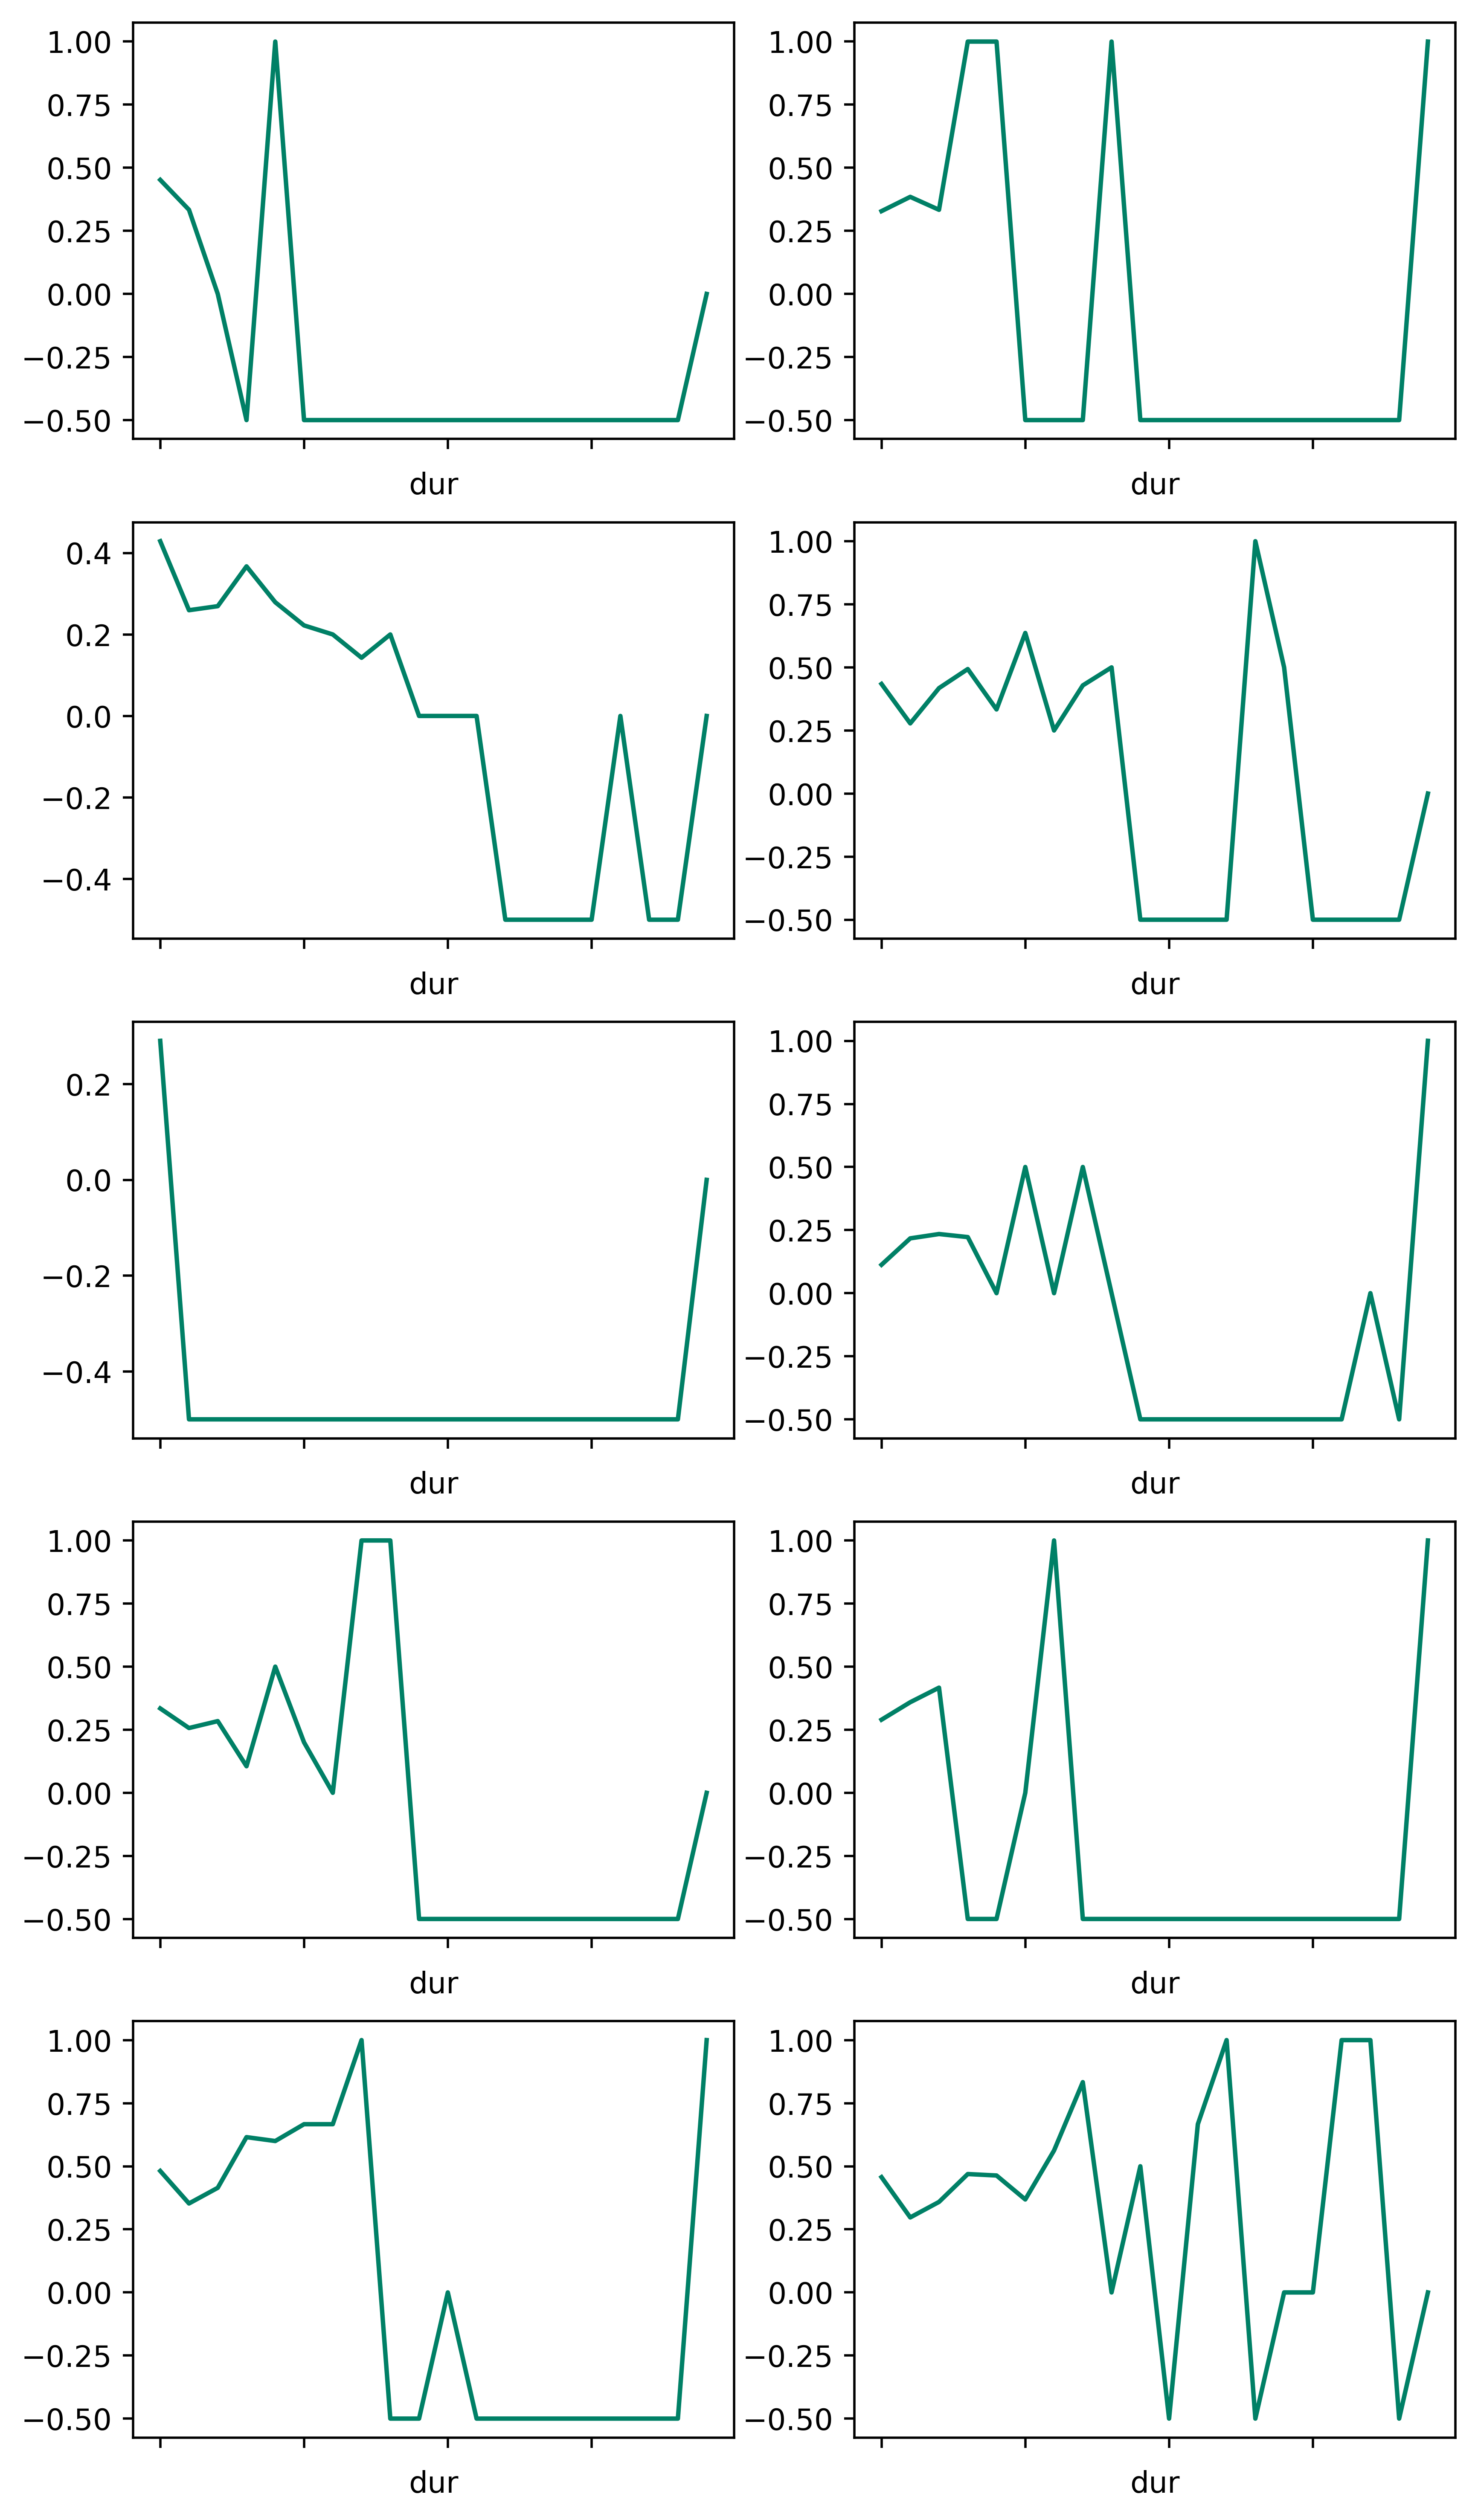

In [128]:
fig2 = plt.figure(figsize=(8,15),dpi=500)

for i in range(size):
    ax[i] = fig2.add_subplot(size/2,2,i+1)
    
    record2 = pick_dur[pick_dur.gid == goal_sort.index[i]]
    draw = record2.groupby(pd.cut(record2['dur'],bins=20)).apply(lambda x:sum(x['corr']==0)/len(x) if len(x)!=0 else -0.5)
    draw.plot(kind='line',colormap='summer')

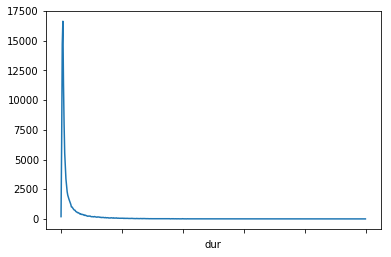

In [170]:
false_pick = pick_dur[(pick_dur['corr'] == 0) & (pick_dur['dur'] < 554646.05) & (pick_dur['dur'] > 0)]
F_draw = false_pick.groupby(pd.cut(false_pick['dur'],bins=500)).apply(lambda x:len(x))
# F_draw
F_draw.plot(kind='line')

In [4]:
def cal_TrueSkill(data):
    user = defaultdict(ts.Rating)
    goal = defaultdict(ts.Rating)
    
    for i in data.iterrows():
        idx = i[0]
        item = i[1]
        # 对每一条迭代进来的记录，分别初始化uid和pid的能力值，然后用上式计算。
        u_player = user[item['uid']]
        g_player = goal[item['gid']]
        
        # 核心句，计算一次做题提交之后，trueskill的变化。根据user做题的对错情况，决定这个delta数值是正还是负。
        data.loc[idx,'ts_pts'] = 2*(item['corr'] - 0.5) * (g_player.mu / u_player.mu)*norm_duration(item)
        # 记录即时的goal与user值，是为了后面计算compensate
        data.loc[idx,'temp_g'] = g_player.mu
        data.loc[idx,'temp_u'] = u_player.mu
    
        if item['corr']:
            u_player,g_player = ts.rate_1vs1(u_player,g_player)
        else :
            g_player,u_player = ts.rate_1vs1(u_player,g_player)
            
        user[item['uid']] = u_player
        goal[item['gid']] = g_player
    return user,goal,data
# user/goal两个defaultdict分别存储某个user或某个goal的实时trueskill；data的‘ts_pts’列，存储该条记录对战过后，user应该发生的trueskill变化

In [20]:
def split_data(cores,data):
    split_num = [i for i in range(0,len(data),len(data)//cores)]
    split_num[-1] = len(data)
    data_seg = [data[split_num[j]:split_num[j+1]] for j in range(len(split_num)-1)]
    return data_seg

### 采用多进程方法进行计算每条记录的‘ts_pts’：
- 注：这里直接用了所有的cpu，在服务器上跑的时候好么？

In [21]:
cores = mps.cpu_count()
pool = mps.Pool(processes=cores)

r = []
data_seg = split_data(cores,data)
for i in data_seg:
    r.append(pool.apply_async(cal_TrueSkill, (i,))) 

pool.close()
pool.join()

res = [i.get() for i in r]
data = pd.concat([i[2] for i in res])

user_ts = defaultdict(ts.Rating)
goal_ts = defaultdict(ts.Rating)

for i in res:
    user_ts.update(i[0])
    goal_ts.update(i[1])

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### 再看看我们的表格data 

In [23]:
data.tail(10)

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts,temp_g,temp_u
271805,5bd9cdb14e4fa563c93bb16d,5bd9b32b37a1c6078d7ba59f,b2d883fe-57e8-11e7-b80c-378e135d2a87,68256,20181031,1,新民中学,2018-10-31 23:43:37,9690ebf2-53f4-11e7-8610-ffb838397af0,0.432314,31.503196,25.271000
271806,5bd9cdc34e4fa563c93bd68e,5bd9b32b37a1c6078d7ba59f,6e2beefc-75c1-11e7-99f3-ff47a7d2619e,16692,20181031,1,新民中学,2018-10-31 23:43:54,9690ebf2-53f4-11e7-8610-ffb838397af0,0.591369,31.196338,27.912678
271807,5bd9ce024e4fa563c93c5c55,5bd9b32b37a1c6078d7ba59f,c89dfe26-75c5-11e7-8157-bfc977a98b79,53647,20181031,1,新民中学,2018-10-31 23:44:48,9690ebf2-53f4-11e7-8610-ffb838397af0,0.389368,30.951475,29.632356
271808,5bd9ce2c4e4fa563c93cb1e3,5bd99ca5d508f43a0f3a7d9b,b31f9640-57e8-11e7-b81c-eb297590a949,132919,20181031,1,新民中学,2018-10-31 23:45:32,96a3f21a-53f4-11e7-8616-5bf7296ab17e,0.322379,27.854049,24.533244
271809,5bd9cee34e4fa563c93e166d,5bd9b32b37a1c6078d7ba59f,fc290758-75c1-11e7-9cd7-ff2d34fe678f,45573,20181031,1,新民中学,2018-10-31 23:48:37,9690ebf2-53f4-11e7-8610-ffb838397af0,0.390093,30.748438,30.856873
271810,5bd9cf044e4fa563c93e52e7,5bd9b32b37a1c6078d7ba59f,18db632a-75ca-11e7-b80b-e7218667489c,34909,20181031,1,新民中学,2018-10-31 23:49:13,9690ebf2-53f4-11e7-8610-ffb838397af0,0.407954,30.575398,31.782566
271811,5bd9cf254e4fa563c93e8d63,5bd9b32b37a1c6078d7ba59f,6069ab72-75c3-11e7-b414-efbc79ae5142,20057,20181031,1,新民中学,2018-10-31 23:49:36,9690ebf2-53f4-11e7-8610-ffb838397af0,0.468601,30.424853,32.512835
271812,5bd9cf494e4fa563c93ed0c9,5bd9b16971de5007ba60ace7,b9a921de-57e8-11e7-b9af-6ba7df29752e,16501,20181031,1,新民中学,2018-10-31 23:50:26,973a0106-53f4-11e7-8654-0718617ce756,0.510729,25.115990,26.110555
271813,5bd9cf6d4e4fa563c93f1439,5bd9b16971de5007ba60ace7,5cd36af8-7b3a-11e7-aa1c-8705033a2960,36023,20181031,1,新民中学,2018-10-31 23:51:03,973a0106-53f4-11e7-8654-0718617ce756,0.398343,24.981430,26.344820
271814,5bd9d0454e4fa563c9406c7d,5bd9b16971de5007ba60ace7,4427c682-7b46-11e7-8132-3fb936db8a73,212988,20181031,1,新民中学,2018-10-31 23:54:37,974564ce-53f4-11e7-8657-27a134c53335,0.236985,25.537359,26.561836


### 有了未被弥补过的ts_pts之后，我们根据它来计算弥补值的系数b：

In [25]:
u_ts_max = max(list(map(lambda x:x.mu,list(user_ts.values()))))
u_ts_min = min(list(map(lambda x:x.mu,list(user_ts.values()))))
g_ts_max = max(list(map(lambda x:x.mu,list(goal_ts.values()))))
g_ts_min = min(list(map(lambda x:x.mu,list(goal_ts.values()))))
b1 = g_ts_min*(2000/600000)**0.3/(u_ts_max-g_ts_min)
b2 = g_ts_max/(g_ts_max-u_ts_min)
b = min(b1,b2)
b

0.057904319453248004

### 有了b之后，我们开始逐行计算弥补项compensate，以及加上compensate更新之后的ts_pts:
- 我们之所以可以这样算，是因为每一轮的得分最终不会影响到trueskill值的更新。即，你这次做错一道难题，你的得分最终是被compensate了，但其实你的trueskill的变化并没有被compensate（其实trueskill算法模块里肯定也帮你这样做了），所以不用重新计算，只需要计算compensate，然后加到ts_pts上即可。

In [26]:
# for i,row in data.iterrows():
#     compensate = (row['temp_g'] / row['temp_u'] - 1) * b
#     data.loc[i,'compensate'] = compensate
#     data.loc[i,'ts_pts'] = data.loc[i,'ts_pts'] + compensate
    
# data

In [29]:
def ts_update(data,b):
    for i,row in data.iterrows():
        compensate = (row['temp_g'] / row['temp_u'] - 1) * b
        data.loc[i,'compensate'] = compensate
        data.loc[i,'ts_pts'] = data.loc[i,'ts_pts'] + compensate
    return data

In [38]:
pool2 = mps.Pool(processes=cores)

r2 = []
data_seg2 = split_data(cores,data)
for i in data_seg2:
    r2.append(pool2.apply_async(ts_update,args=(i,b,)))

pool2.close()
pool2.join()

res2 = [i.get() for i in r2]
data = pd.concat([i for i in res2])

### 看一下compensate之后的data：

In [48]:
sum((data['corr'] - 0.5) * data['ts_pts'] <0)    # 确认一下，没人做对了题得分为负，也没人做错了题得分为正

0

In [51]:
data.tail()

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts,temp_g,temp_u,compensate
271810,5bd9cf044e4fa563c93e52e7,5bd9b32b37a1c6078d7ba59f,18db632a-75ca-11e7-b80b-e7218667489c,34909,20181031,1,新民中学,2018-10-31 23:49:13,9690ebf2-53f4-11e7-8610-ffb838397af0,0.405754,30.575398,31.782566,-0.002199
271811,5bd9cf254e4fa563c93e8d63,5bd9b32b37a1c6078d7ba59f,6069ab72-75c3-11e7-b414-efbc79ae5142,20057,20181031,1,新民中学,2018-10-31 23:49:36,9690ebf2-53f4-11e7-8610-ffb838397af0,0.464882,30.424853,32.512835,-0.003719
271812,5bd9cf494e4fa563c93ed0c9,5bd9b16971de5007ba60ace7,b9a921de-57e8-11e7-b9af-6ba7df29752e,16501,20181031,1,新民中学,2018-10-31 23:50:26,973a0106-53f4-11e7-8654-0718617ce756,0.508523,25.115990,26.110555,-0.002206
271813,5bd9cf6d4e4fa563c93f1439,5bd9b16971de5007ba60ace7,5cd36af8-7b3a-11e7-aa1c-8705033a2960,36023,20181031,1,新民中学,2018-10-31 23:51:03,973a0106-53f4-11e7-8654-0718617ce756,0.395346,24.981430,26.344820,-0.002997
271814,5bd9d0454e4fa563c9406c7d,5bd9b16971de5007ba60ace7,4427c682-7b46-11e7-8132-3fb936db8a73,212988,20181031,1,新民中学,2018-10-31 23:54:37,974564ce-53f4-11e7-8657-27a134c53335,0.234751,25.537359,26.561836,-0.002233


### 计算下列内容：
- 1.某学校总做题量；                                **final_res['做题量']**
- 2.参与进来的用户总数；                             **final_res['用户总数']**
- 3.某学校每位用户平均做题量；                        **final_res['人均题量']**
- 4.利用F1积分法等方法得到的合理的学校总分；            **final_res['总分Func']**
- 5.学校学生的平均trueskill；                      **final_res['人均TrueSkill']**
- 6.每个学校涉及到的知识点goal总数；                 **final_res['知识点数']**                      
- 7.本学校拿到前三名的知识点goal数量（及是哪些goal）；

In [52]:
final_res = pd.DataFrame(dict())

In [53]:
final_res['做题量'] = data.groupby('sch_name').apply(lambda x: len(x))

In [54]:
uid_count = [len(x) for x in data.groupby('sch_name').uid.unique()]

final_res['用户总数'] = uid_count
final_res['人均题量'] = final_res['做题量'].values / uid_count

In [55]:
sch_user_ts = data[['uid','sch_name']]
sch_user_ts = sch_user_ts.drop_duplicates()
sch_user_ts['trueskill'] = sch_user_ts.uid.apply(lambda x:user_ts[x].mu)  
# 因为我们无法把duration的计算加入trueskill公式中，因而在计算trueskill的只好忽略掉它。但涉及到最后排名时，duration会被用上。
final_res['人均TrueSkill'] = sch_user_ts.groupby('sch_name').apply(lambda x:x['trueskill'].mean())

In [56]:
final_res['知识点数'] = data.groupby('sch_name').apply(lambda x:len(x.gid.unique()))

In [57]:
# 每个知识点下每个学校得分排名：
rs = data.groupby(['gid','sch_name']).apply(lambda x: sum(x.ts_pts))
rs = pd.DataFrame(rs).reset_index()
rs.columns = ['gid', 'sch_name', 'pt']
rs['rank_int'] = rs[['gid', 'pt']].groupby(['gid']).rank(ascending=0)
rs['rank_pct'] = rs[['gid','pt']].groupby('gid').rank(ascending=True,method='max',pct=True)
rs['Func_pt'] = rs['rank_pct'].apply(lambda x:pow((x**8),1/3)*25)
rs

,gid,sch_name,pt,rank_int,rank_pct,Func_pt
0,006f814e-b329-11e7-aab6-b3208c44f7d9,临沂十一中,-4.952026,3.0,0.600000,6.402408
1,006f814e-b329-11e7-aab6-b3208c44f7d9,南宁二中,-0.360777,1.0,1.000000,25.000000
2,006f814e-b329-11e7-aab6-b3208c44f7d9,新民中学,-1.756799,2.0,0.800000,13.788382
3,006f814e-b329-11e7-aab6-b3208c44f7d9,武陵中学,-5.469197,4.0,0.400000,2.171534
4,006f814e-b329-11e7-aab6-b3208c44f7d9,莒南七中,-11.017030,5.0,0.200000,0.341995
5,01f90096-7123-11e7-b3a9-2b20ad1b4a83,临沂十一中,-6.503564,5.0,0.200000,0.341995
6,01f90096-7123-11e7-b3a9-2b20ad1b4a83,南宁二中,-0.927884,2.0,0.800000,13.788382
7,01f90096-7123-11e7-b3a9-2b20ad1b4a83,新民中学,1.600656,1.0,1.000000,25.000000
8,01f90096-7123-11e7-b3a9-2b20ad1b4a83,武陵中学,-3.859727,4.0,0.400000,2.171534
9,01f90096-7123-11e7-b3a9-2b20ad1b4a83,莒南七中,-1.736981,3.0,0.600000,6.402408


In [58]:
final_res['总分Func'] = rs.groupby('sch_name').apply(lambda x:sum(x['Func_pt']))
final_res['平均顺位'] = rs.groupby('sch_name').apply(lambda x:x['rank_int'].mean())
final_res['得到第一的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] == 1))
final_res['得到前二的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] < 2.1))
final_res['得到前三的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] < 3.1))
final_res['6名开外次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] > 6.9))

In [59]:
final_res.sort_values(by='总分Func',ascending=False)
# 注意吴有训和双语，吴有训在Func中反超了双语，就是因为他们前二名的次数明显多于双语学校。可见Func法对排名靠前的学校的得分有较好的区分度

,做题量,用户总数,人均题量,人均TrueSkill,知识点数,总分Func,平均顺位,得到第一的次数,得到前二的次数,得到前三的次数,6名开外次数
sch_name,,,,,,,,,,,
莒南七中,93726,608,154.154605,26.275871,934,10626.891886,3.501071,304,432,540,146
新民中学,14813,348,42.566092,26.581870,845,8203.259258,3.579882,152,285,420,69
武陵中学,70757,601,117.732113,26.229467,911,7459.947265,4.194292,152,321,432,200
临沂十一中,57048,808,70.603960,26.505530,854,6213.399715,4.268150,76,220,395,169
城关中学,13001,482,26.973029,27.157536,568,5799.174772,3.889085,116,204,274,95
南宁二中,5027,154,32.642857,26.425472,604,5572.851726,3.933775,78,178,266,70
双语学校,11387,347,32.815562,27.503314,450,4128.691109,4.186667,58,122,197,79
吴有训实验学校,3415,113,30.221239,26.369408,403,3662.978540,4.188586,53,115,175,77
广东实验中学,1714,67,25.582090,25.636159,380,3302.427105,4.284211,46,100,160,64


### 以吴有训实验学校为例，计算该校每个用户对于学校总成绩的贡献值：
- 以百分数形式表现

In [61]:
wu = data[data['sch_name'] == '吴有训实验学校']
ts_wu = pd.DataFrame(dict())
ts_wu['ts'] = wu.groupby('uid').apply(lambda x:sum(x['ts_pts']))

ts_wu['rank'] = ts_wu.rank(method='min',ascending=True,pct=True)

In [62]:
ts_wu.sort_values(by='ts',ascending=False)

,ts,rank
uid,,
5b9a6afd054352062d54c1d2,23.567832,1.000000
5b9c74a620867a22e6a21ead,19.071551,0.991150
5bcab216aa863e07e36d0243,15.422682,0.982301
59f0950b3d3672091295c132,13.385683,0.973451
59f040cb9dcce33008c725c3,11.567198,0.964602
5b99d0ce3ba133062b33e55c,10.926679,0.955752
5b8b908c6ce1ce06318ec217,10.352653,0.946903
5b8b91126ce1ce06318ec25d,9.320699,0.938053
5b8b91126ce1ce06318ec26a,8.346198,0.929204
